#### Importing data from Kaggle

In [ ]:
!pip install kaggle
import zipfile
import os

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


dataset_zip_path = "chest-xray-pneumonia.zip"
dataset_path = "/content/chest_xray/"
os.makedirs(dataset_path, exist_ok=True)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print(f"Dataset extracted to {dataset_path}")

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset extracted to /content/chest_xray/


#### Extracting Dataset

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

import zipfile
import os

dataset_zip_path = "chest-xray-pneumonia.zip"
dataset_path = "/content/chest_xray/"
os.makedirs(dataset_path, exist_ok=True)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

print(f"Dataset extracted to {dataset_path}")


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset extracted to /content/chest_xray/


#### Defining paths

In [ ]:
train_dir = os.path.join(dataset_path, "chest_xray/train")
val_dir = os.path.join(dataset_path, "chest_xray/val")
test_dir = os.path.join(dataset_path, "chest_xray/test")


#### Data Augmentation and transformation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    zoom_range=0.3
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Defining Resnet

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_resnet50(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet50((IMG_HEIGHT, IMG_WIDTH, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Defining Densnet

In [ ]:
from tensorflow.keras.applications import DenseNet121

def build_densenet121(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

densenet_model = build_densenet121((IMG_HEIGHT, IMG_WIDTH, 3))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Defining Googlenet

In [ ]:
from tensorflow.keras.applications import InceptionV3

def build_googlenet(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

googlenet_model = build_googlenet((IMG_HEIGHT, IMG_WIDTH, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### Handling Class Imbalance

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights_dict = dict(enumerate(class_weights))


#### Callbacks for early stopping in training if model's accuracy is decreasing

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint_resnet = ModelCheckpoint("resnet_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_densenet = ModelCheckpoint("densenet_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_googlenet = ModelCheckpoint("googlenet_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

#### Model Training

In [ ]:
# Train ResNet
resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint_resnet],
    class_weight=class_weights_dict
)

# Train DenseNet
densenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint_densenet],
    class_weight=class_weights_dict
)

# Train GoogLeNet
googlenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint_googlenet],
    class_weight=class_weights_dict
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.5782 - loss: 1.7896
Epoch 1: val_loss improved from inf to 0.73030, saving model to resnet_best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 704ms/step - accuracy: 0.5785 - loss: 1.7854 - val_accuracy: 0.5625 - val_loss: 0.7303 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.6811 - loss: 0.7048
Epoch 2: val_loss improved from 0.73030 to 0.72840, saving model to resnet_best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 714ms/step - accuracy: 0.6811 - loss: 0.7048 - val_accuracy: 0.6875 - val_loss: 0.7284 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6974 - loss: 0.6917
Epoch 3: val_loss improved from 0.72840 to 0.70326, saving model to resnet_best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 700ms/step - accuracy: 0.6974 - loss: 0.6917 - val_accuracy: 0.6250 - val_loss: 0.7033 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━

#### Importing Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the best models
best_resnet = load_model("/content/resnet_best_model.keras")
best_densenet = load_model("/content/densenet_best_model.keras")
best_googlenet = load_model("/content/googlenet_best_model.keras")


#### Model Testing

In [ ]:
# Evaluate ResNet-50
resnet_results = best_resnet.evaluate(test_data)
print(f"ResNet Test Accuracy: {resnet_results[1]:.4f}, Loss: {resnet_results[0]:.4f}")

# Evaluate DenseNet-121
densenet_results = best_densenet.evaluate(test_data)
print(f"DenseNet Test Accuracy: {densenet_results[1]:.4f}, Loss: {densenet_results[0]:.4f}")

# Evaluate GoogLeNet
googlenet_results = best_googlenet.evaluate(test_data)
print(f"GoogLeNet Test Accuracy: {googlenet_results[1]:.4f}, Loss: {googlenet_results[0]:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 405ms/step - accuracy: 0.8325 - loss: 0.5385
ResNet Test Accuracy: 0.7324, Loss: 0.6160
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 734ms/step - accuracy: 0.8987 - loss: 0.6849
DenseNet Test Accuracy: 0.8638, Loss: 0.7666
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 505ms/step - accuracy: 0.8407 - loss: 0.9466
GoogLeNet Test Accuracy: 0.7949, Loss: 1.0142


#### Ensemble Learning

Ensemble Test Accuracy: 0.8542
Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.90      0.82       234
   Pneumonia       0.93      0.83      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.86      0.85       624
weighted avg       0.87      0.85      0.86       624



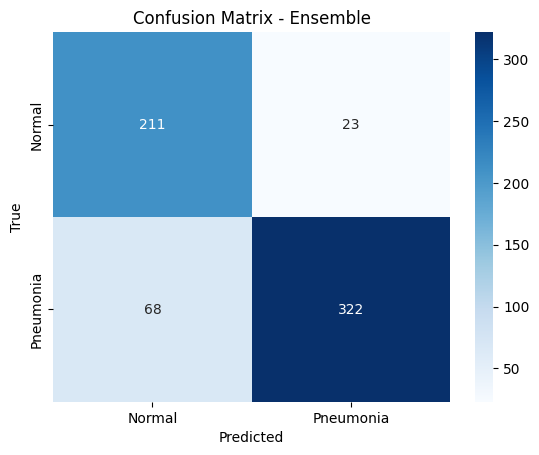

In [ ]:
import numpy as np

def ensemble_predictions(models, data, weights):
    predictions = [model.predict(data, verbose=0) for model in models]
    weighted_preds = np.average(predictions, axis=0, weights=weights)
    return np.round(weighted_preds).flatten()

# Ensemble the predictions with weights
models = [best_resnet, best_densenet, best_googlenet]
weights = [0.4, 0.3, 0.3]  # Example weights; adjust based on validation performance
ensemble_preds = ensemble_predictions(models, test_data, weights)

# Evaluate ensemble performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_true = test_data.classes
ensemble_accuracy = accuracy_score(y_true, ensemble_preds)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_true, ensemble_preds, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Ensemble")
plt.show()


#### Plotting ROC Curve of Ensemble model

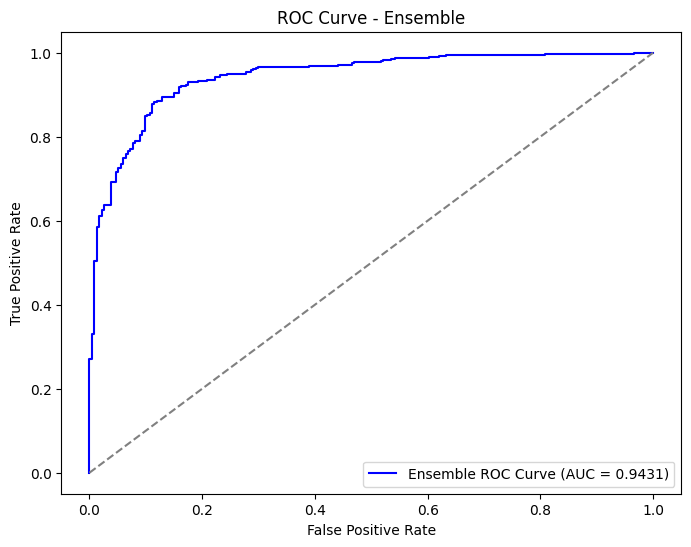

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
y_probs = np.average([model.predict(test_data, verbose=0) for model in models], axis=0, weights=weights)
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"Ensemble ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Ensemble")
plt.legend(loc="lower right")
plt.show()


#### Saving the model

In [ ]:
# Save the ensemble predictions
np.save("ensemble_predictions.npy", ensemble_preds)

#### Prediction of pneumonia for 10 random images from test set.

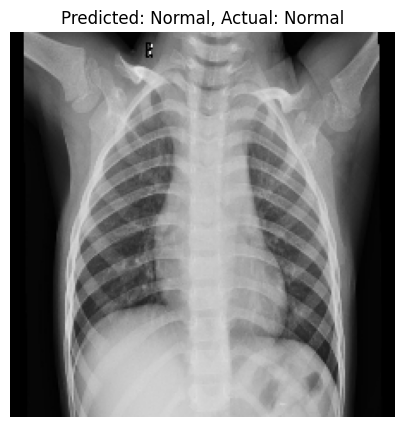

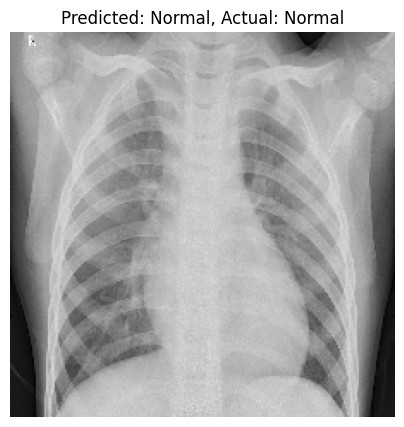

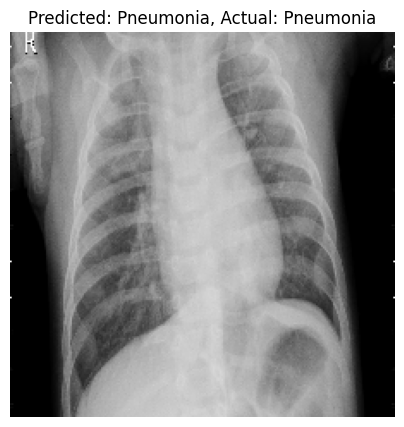

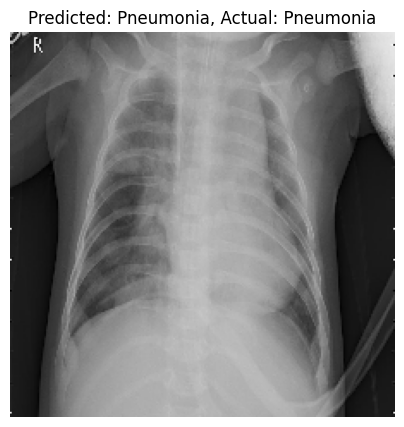

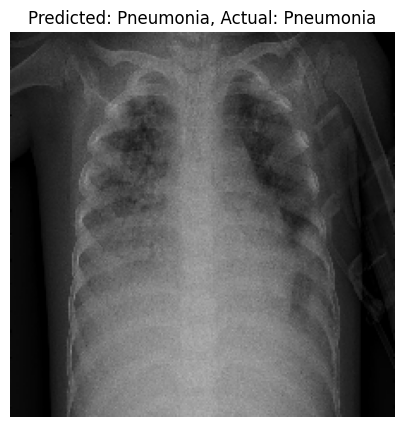

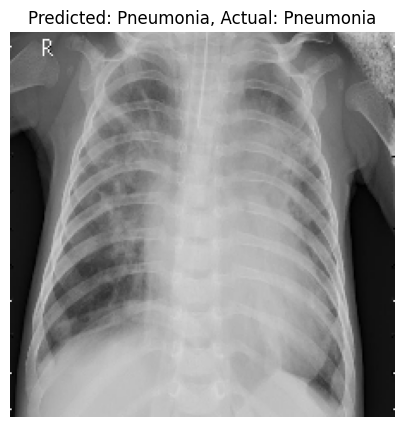

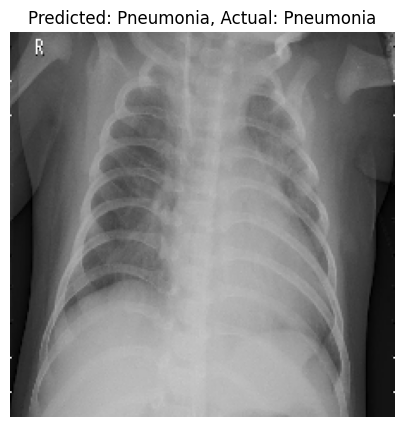

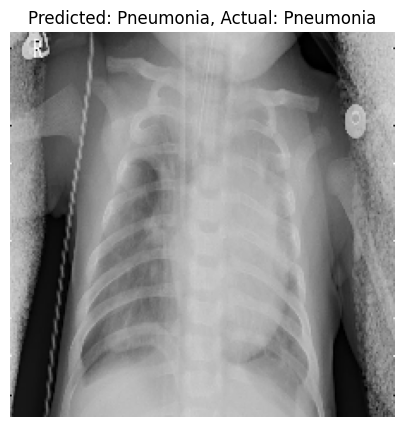

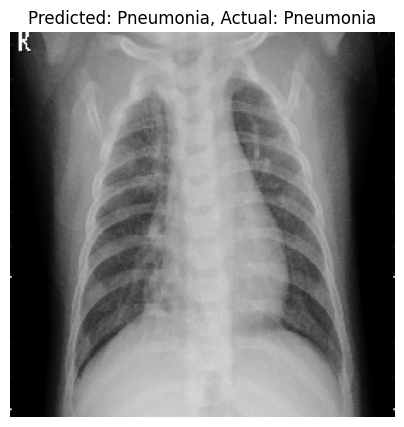

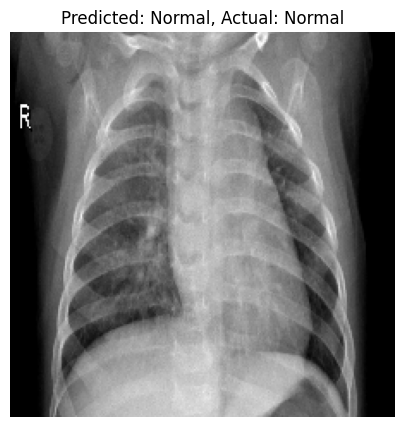

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

# Load ensemble predictions
ensemble_predictions = np.load("ensemble_predictions.npy")

# Get test data details
test_image_paths = test_data.filepaths  # File paths of test images
test_labels = test_data.classes         # Actual labels from test data

# Map labels to class names
label_map = {0: 'Normal', 1: 'Pneumonia'}

# Select 10 random test images
random_indices = random.sample(range(len(test_image_paths)), 10)

# Visualize predictions for these images
for i in random_indices:
    # Load the image
    img_path = test_image_paths[i]
    actual_label = test_labels[i]
    predicted_label = int(ensemble_predictions[i])

    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Plot the image with prediction and actual label
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {label_map[predicted_label]}, Actual: {label_map[actual_label]}")
    plt.show()
